<center>

| Nazwa przedmiotu                          | Dataset                                |
| ----------------------------------------- | -------------------------------------- |
| Projekt zespołowy - sztuczna inteligencja | laptop_prices_dataset                  |
|                                           |                                        |
| Piotr                                     | Goraj                                  |
| Numer albumu                              | 55529                                  |
|                                           |                                        |
| Bartosz                                   | Kiałka                                 |
| Numer albumu                              | 55528                                  |
|                                           |                                        |
| Data oddania sprawozdania                 | 2024.11.16                             |
| Kierunek                                  | Informatyka, II stopnia P, Stacjonarne |

</center>


Nazwa przedmiotu: Projekt zespołowy - sztuczna inteligencja

Kierunek: Informatyka, II stopnia P, Stacjonarne

Dataset: laptop_prices_dataset https://www.kaggle.com/datasets/owm4096/laptop-prices/data



Autorzy:

Piotr Goraj, nr. alb. 55529

Bartosz Kiałka, nr. alb. 55528



Data oddania sprawozdania: 2024.11.16

## 1. Instalacja i import bibliotek

In [1]:
# !pip install pandas
# !pip install scikit-learn
# !pip install numpy
# !pip install shap
# !pip install matplotlib
# !pip install seaborn
# !pip install --upgrade shap scikit-learn pandas numpy matplotlib

# !pip install --upgrade shap scikit-learn pandas numpy matplotlib
# !pip install --upgrade shap
# !pip install --upgrade matplotlib seaborn scikit-learn

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns


## 2. Odczyt danych do modelu

In [3]:
TRAIN_FILE_PATH = './train_data.csv'
VAL_FILE_PATH = './val_data.csv'
TEST_FILE_PATH = './test_data.csv'

train_model_data = pd.read_csv(TRAIN_FILE_PATH)
val_model_data = pd.read_csv(VAL_FILE_PATH)
test_model_data = pd.read_csv(TEST_FILE_PATH)

## 3. Model predykcyjny - Regresja

#### Kluczowe pojęcia:

  - Hiperparametry: Są to parametry, które musisz ustawić przed rozpoczęciem treningu modelu (np. wartość współczynnika regularizacji w Lasso). Różnią się od parametrów modelu, które są wyznaczane podczas treningu (np. współczynniki w regresji liniowej).

  - Grid Search/Random Search: Techniki przeszukiwania przestrzeni hiperparametrów w celu znalezienia najlepszych ustawień. Grid Search testuje wszystkie kombinacje, a Random Search losowo wybiera kombinacje.

  - Skalowanie danych (MinMaxScaler): Przekształca dane tak, aby mieściły się w określonym przedziale (zwykle od 0 do 1). Jest to ważne, ponieważ wiele algorytmów (w tym regresja) działa lepiej, gdy cechy są na tej samej skali.

In [4]:
# podział na cechy (X) oraz etykiety (y)
X_train = train_model_data.drop(columns=['Price_euros'])  
y_train = train_model_data['Price_euros']

X_val = val_model_data.drop(columns=['Price_euros'])
y_val = val_model_data['Price_euros']

X_test = test_model_data.drop(columns=['Price_euros'])
y_test = test_model_data['Price_euros']

# połączenie zbioru treningowego i walidacyjnego
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# ujednolicenie kolumn i ich kolejności
def align_and_sort_columns(train, test):
    all_columns = train.columns.tolist()
    for col in all_columns:
        if col not in test.columns:
            test[col] = 0
    return train, test[all_columns]

X_train_combined, X_test = align_and_sort_columns(X_train_combined, X_test)

# skalowanie danych
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test) # Użycie fit_transform tylko na danych treningowych

In [5]:
# regresja liniowa i Lasso
linear_model = LinearRegression()
lasso_model = Lasso()

In [6]:
''' 
  Hiperparametry to parametry, które są ustawiane przed rozpoczęciem treningu modelu 
  i kontrolują jego działanie oraz sposób uczenia się. Dobór hiperparametrów wpływa 
  na jakość i wydajność modelu.
'''
# optymalizacja hiperparametrów dla Lasso
## Hiperparametr alpha kontroluje siłę regularizacji - małe wartości oznaczają słabszą regularyzacje,
## mogą prowadzić do overfittingu (nadmiernego dopasowania). Duże wartości natomiast mogą prowadzić do
## uderfittingu.
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search_lasso.fit(X_train_scaled, y_train_combined)

random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_grid, n_iter=5, 
                                         cv=5, scoring='r2', random_state=42)
random_search_lasso.fit(X_train_scaled, y_train_combined)

# najlepszy model Lasso
## best_estimator_ - to atrybut GridSearchCV, który przechowuje najlepszy model 
## (czyli ten, który osiągnął najwyższy wynik dla wybranej metryki)
best_lasso_model_grid = grid_search_lasso.best_estimator_
best_lasso_model_random = random_search_lasso.best_estimator_

In [7]:
# trenowanie modeli
linear_model.fit(X_train_scaled, y_train_combined)
best_lasso_model_grid.fit(X_train_scaled, y_train_combined)
best_lasso_model_random.fit(X_train_scaled, y_train_combined)

# predykcje
y_pred_linear = linear_model.predict(X_test_scaled)
y_pred_lasso_grid = best_lasso_model_grid.predict(X_test_scaled)
y_pred_lasso_random = best_lasso_model_random.predict(X_test_scaled)

In [8]:
# ocena modeli
def evaluate_model(y_true, y_pred, model_name):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Wyniki dla {model_name}:")
    print(f"Średnia rzeczywista: {mean_true:.4f}")
    print(f"Średnia przewidywana: {mean_pred:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("-" * 30)

evaluate_model(y_test, y_pred_linear, "Regresja Liniowa")
evaluate_model(y_test, y_pred_lasso_grid, "Lasso - GridSearch")
evaluate_model(y_test, y_pred_lasso_random, "Lasso - RandomSearch")

Wyniki dla Regresja Liniowa:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8553
R2: 0.7117
RMSE: 0.3243
MAE: 0.2544
------------------------------
Wyniki dla Lasso - GridSearch:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8444
R2: 0.6638
RMSE: 0.3502
MAE: 0.2893
------------------------------
Wyniki dla Lasso - RandomSearch:
Średnia rzeczywista: 6.8673
Średnia przewidywana: 6.8444
R2: 0.6638
RMSE: 0.3502
MAE: 0.2893
------------------------------


In [ ]:
'''
  Średnia rzeczywista oraz przewidywana - jeżali różnica między średnią 
  rzeczywistą a przewidywaną jest mała model dobrze odtwarza ogólną tendencję danych.

  R^2 - Współczynnik determinacji. Określa jaka część wariancji zmiennej zależnej 
    jest wyjaśniana przez model. Przyjmuje wartości ujemne (jeśli model jest bardzo słaby) 
    do 1 (wtedy model jest przeuczony)

  RMSE - Root Mean Squared Error - to pierwiastek kwadratowy średniej błędów kwadratowych 
    między rzeczywistymi a przewidywanymi wartościami. Im wartość RMSE jest mniejsza tym lepiej.
  
  MAE - Mean Absolute Error -  oblicza średnią z wartości bezwzględnych różnic między 
    przewidywanymi a rzeczywistymi wartościami. Im wartość niższa tym lepszy model.
'''

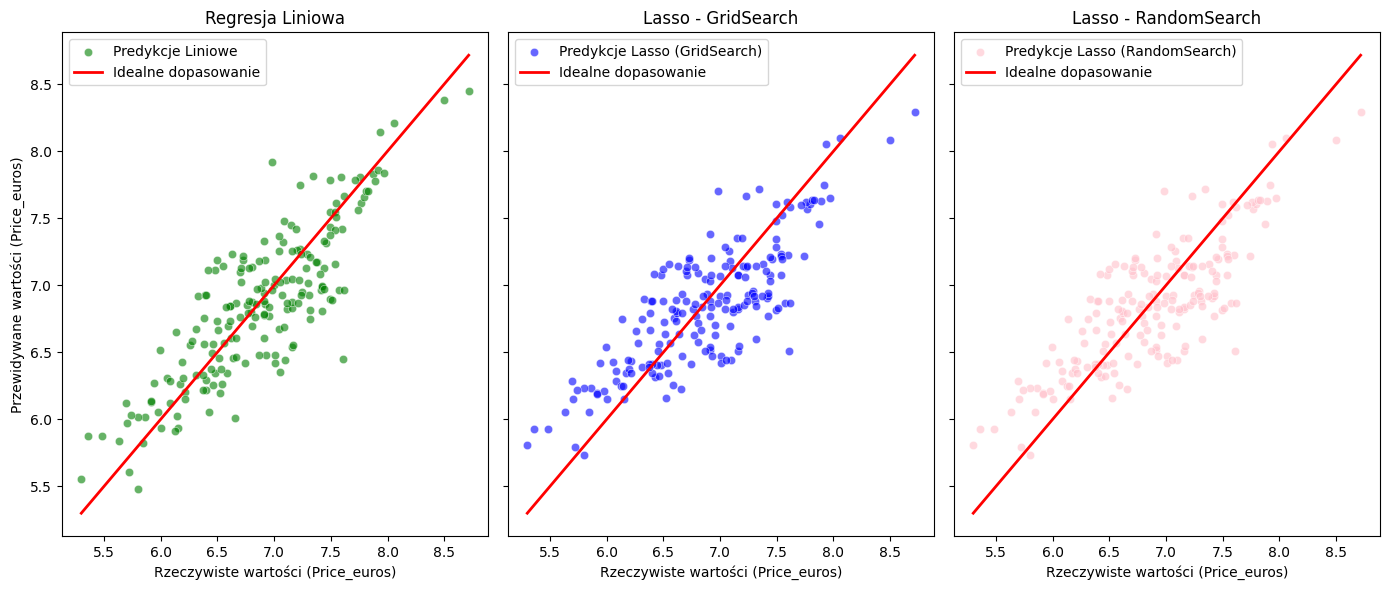

In [10]:
# wykresy predykcji vs idealnych dopasowań 
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True) 

# wykres dla regresji liniowej
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.6, color='green', label='Predykcje Liniowe', ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[0].set_title("Regresja Liniowa")
axes[0].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[0].set_ylabel("Przewidywane wartości (Price_euros)")
axes[0].legend()

# wykresy dla modeli Lasso
sns.scatterplot(x=y_test, y=y_pred_lasso_grid, alpha=0.6, color='blue', label='Predykcje Lasso (GridSearch)', ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[1].set_title("Lasso - GridSearch")
axes[1].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[1].legend()

sns.scatterplot(x=y_test, y=y_pred_lasso_random, alpha=0.6, color='pink', label='Predykcje Lasso (RandomSearch)', ax=axes[2])
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Idealne dopasowanie')
axes[2].set_title("Lasso - RandomSearch")
axes[2].set_xlabel("Rzeczywiste wartości (Price_euros)")
axes[2].legend()

plt.tight_layout()
plt.show()

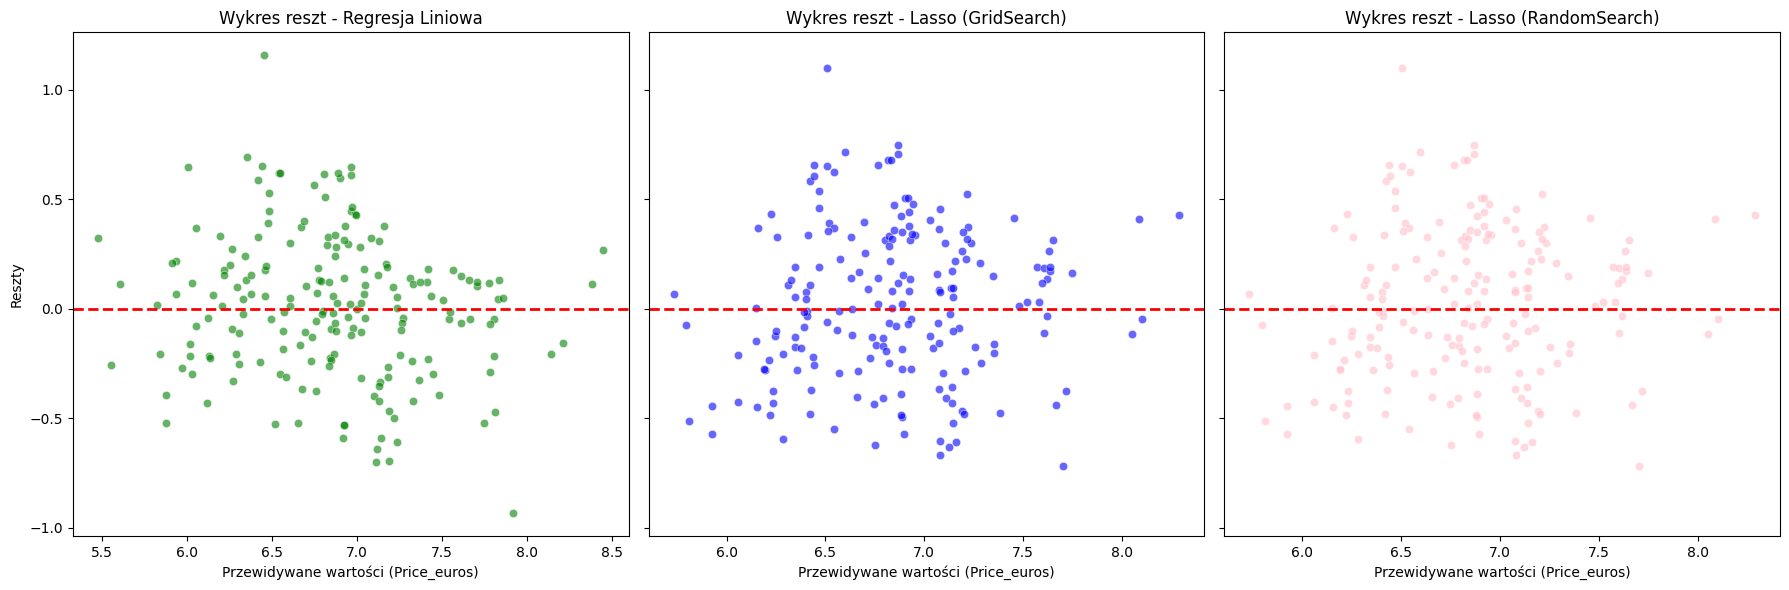

In [11]:
# reszty dla każdego modelu
residuals_linear = y_test - y_pred_linear
residuals_lasso_grid = y_test - y_pred_lasso_grid
residuals_lasso_random = y_test - y_pred_lasso_random

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# wykres dla regresji liniowej
sns.scatterplot(x=y_pred_linear, y=residuals_linear, alpha=0.6, color='green', ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--', lw=2)
axes[0].set_title("Wykres reszt - Regresja Liniowa")
axes[0].set_xlabel("Przewidywane wartości (Price_euros)")
axes[0].set_ylabel("Reszty")

# wykres dla Lasso (GridSearch)
sns.scatterplot(x=y_pred_lasso_grid, y=residuals_lasso_grid, alpha=0.6, color='blue', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_title("Wykres reszt - Lasso (GridSearch)")
axes[1].set_xlabel("Przewidywane wartości (Price_euros)")

# wykres dla Lasso (RandomSearch)
sns.scatterplot(x=y_pred_lasso_random, y=residuals_lasso_random, alpha=0.6, color='pink', ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--', lw=2)
axes[2].set_title("Wykres reszt - Lasso (RandomSearch)")
axes[2].set_xlabel("Przewidywane wartości (Price_euros)")

plt.tight_layout()
plt.show()


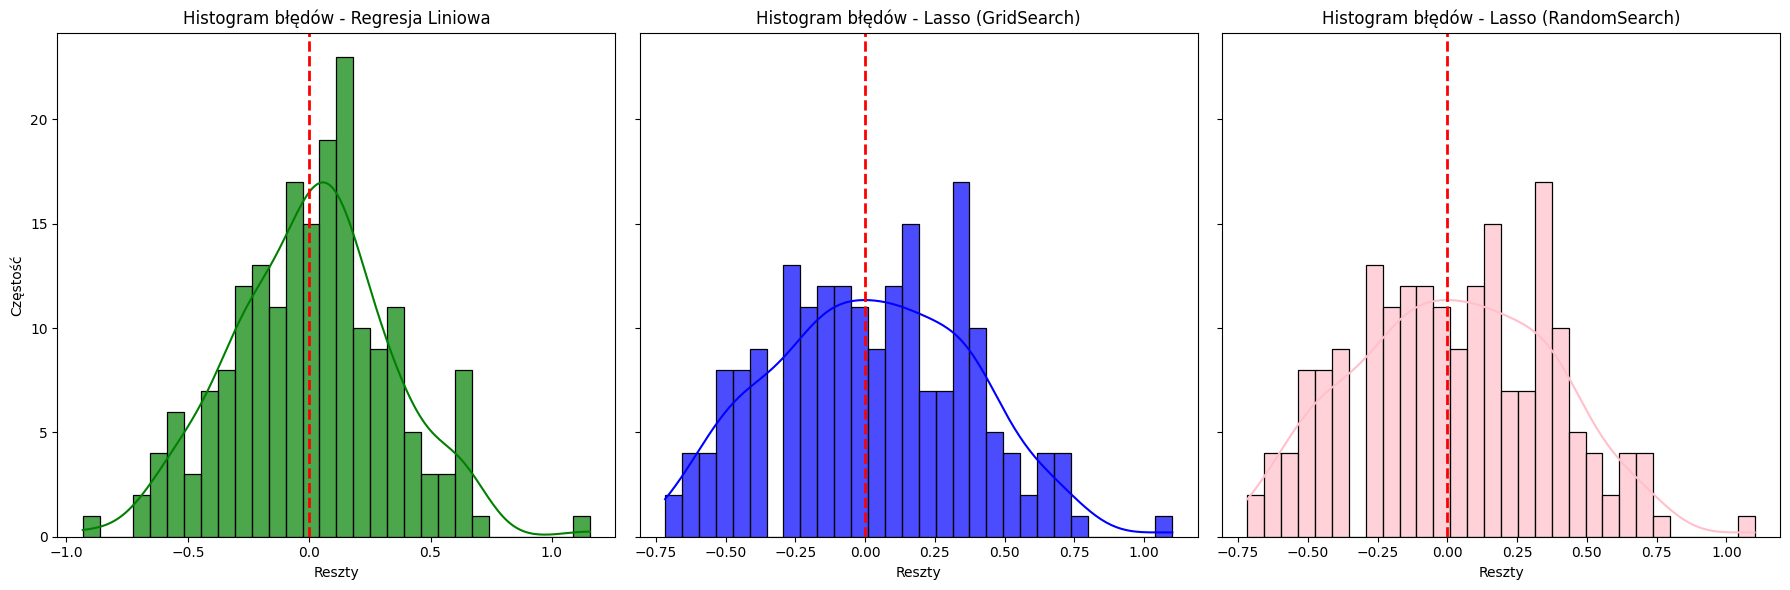

In [12]:
# wykresy histogramów błędów
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# histogram dla regresji liniowej
sns.histplot(residuals_linear, kde=True, bins=30, color='green', alpha=0.7, ax=axes[0])
axes[0].axvline(0, color='red', linestyle='--', lw=2)
axes[0].set_title("Histogram błędów - Regresja Liniowa")
axes[0].set_xlabel("Reszty")
axes[0].set_ylabel("Częstość")

# histogram dla Lasso (GridSearch)
sns.histplot(residuals_lasso_grid, kde=True, bins=30, color='blue', alpha=0.7, ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_title("Histogram błędów - Lasso (GridSearch)")
axes[1].set_xlabel("Reszty")

# histogram dla Lasso (RandomSearch)
sns.histplot(residuals_lasso_random, kde=True, bins=30, color='pink', alpha=0.7, ax=axes[2])
axes[2].axvline(0, color='red', linestyle='--', lw=2)
axes[2].set_title("Histogram błędów - Lasso (RandomSearch)")
axes[2].set_xlabel("Reszty")

plt.tight_layout()
plt.show()
